In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1,3,7"

In [2]:
import sys
import torch
import pandas as pd
import numpy as np
import random 
from torch.utils.data import DataLoader
import torch.nn as nn
import misc_title

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
sys.path.insert(0,'../src_title/')
import config, dataset, model, engine, utils, model_parameters

In [5]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
set_seed(7) 

In [6]:
df_train, df_test = utils.split_data() ## Read the data 

In [7]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,news_id,url,title,content,images,tweet_ids,image_list,label,clean_nb_imgs
0,0,984,gossipcop-3507938806,www.foxnews.com/entertainment/2017/07/12/donal...,Donald Trump Jr. releases email exchange: Cele...,Donald Trump Jr. has been making headlines thi...,['fake_gossipcop-3507938806_headshot-48513.jpg...,885131701877428224\t885131769896472577\t885131...,['fake_gossipcop-3507938806_headshot-48513.jpg...,1,3
1,1,1579,gossipcop-8115207261,www.dailystar.co.uk/showbiz/678030/Lady-Gaga-p...,What has Lady Gaga done to her face? Plastic s...,The video will auto-play soon 8 Cancel\n\nSign...,['fake_gossipcop-8115207261_1219768.jpg'],958296018965225472\t958331247956320256\t958343...,['fake_gossipcop-8115207261_1219768.jpg'],1,1
2,2,657,gossipcop-7544598697,www.hollywoodreporter.com/news/oscars-2017-mem...,"Oscars ""In Memoriam"": Garry Shandling, Robert ...","Oscars ""In Memoriam"": Garry Shandling, Robert ...",['fake_gossipcop-7544598697_split_vaughn_shand...,836090741512273921\t836092215893995520\t836098...,['fake_gossipcop-7544598697_split_vaughn_shand...,1,2
3,3,952,gossipcop-3645597267,www.girlfriend.com.au/kourtney-kardashian-blas...,Kourtney Kardashian blasts pregnant sister Khl...,Video from the upcoming season finale of Keepi...,['fake_gossipcop-3645597267_1000-khloe-kourtne...,970403514911358976\t992690721353236482\t102183...,['fake_gossipcop-3645597267_1000-khloe-kourtne...,1,1
4,5,1077,gossipcop-1363170506,pagesix.com/2017/10/31/the-text-that-changed-e...,The text that changed everything for J.Lo and ...,Click to email this to a friend (Opens in new ...,['fake_gossipcop-1363170506_alex-jennifer.jpg'...,966067473316491265\t966071495192702976\t966071...,['fake_gossipcop-1363170506_alex-jennifer.jpg'...,1,2


In [8]:
df_train.groupby("label").count()

,Unnamed: 0,Unnamed: 0.1,news_id,url,title,content,images,tweet_ids,image_list,clean_nb_imgs
label,,,,,,,,,,
0,758,758,758,758,758,758,758,758,0,758
1,2040,2040,2040,2040,2040,2040,2040,2040,2040,2040


In [9]:
## Create the data Loaders

train_dataset = dataset.FakeNewsDataset(df_train)

## using padding
train_data_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, collate_fn=dataset.MyCollate())



val_dataset = dataset.FakeNewsDataset(df_test)

## using padding
val_data_loader = DataLoader(val_dataset, batch_size=config.EVAL_BATCH_SIZE,
                        shuffle=True, collate_fn=dataset.MyCollate())

In [10]:
## to get component wise loss
def sim_loss(x, y):
    
    ## Create centroid (mean along dim=1 as x=(batch, nb_components, mulimodal_space_dim))
    centroid = torch.mean(x, dim=1, keepdim=True)

    centroid = centroid.repeat(1, x.size(1), 1)

    y = y.unsqueeze(1).repeat(1, x.size(1))

    batch_size = x.shape[0]

    # Squash samples and timesteps into a single axis
    x_reshape = x.contiguous().view(-1, x.size(-1))  # (b_s * num_components, latent_dim)

    centroid_reshape = centroid.contiguous().view(-1, centroid.size(-1))  # (b_s * num_components, latent_dim)
    
    ## Calculate distance of each component from the centroid
    dist_mat = config.PDIST(x_reshape, centroid_reshape).view(batch_size, -1)

    total_loss = torch.mean(dist_mat, dim=1)

    return total_loss 

In [18]:
EXP_NAME = "raw_PF_padding_title_exp_new_1_save" # clean_GC_padding_title_exp_new_1_save
MODEL_PATH = f'/media/nas_mount/Shivangi/mudit/log/saved_model/{EXP_NAME}.pt'

## Either run the model again or read csv file 

In [12]:
## Set the device and initialize the model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.Multiple_Images_Model()

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

Using 3 GPUs


/home/shivangi/.conda/envs/fakenews/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 2. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [13]:
loaded_state_dict = torch.load(MODEL_PATH,  map_location=device)

In [14]:
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [20]:
df_space, df_mean = misc_title.create_multimodal_space_df(model_parameters.MULTIMODAL_SPACE_DIM)
df_space, df_mean = misc_title.create_space(df_space, df_mean, model, val_data_loader, sim_loss, device)

 58%|█████▊    | 397/680 [01:32<01:40,  2.82it/s]/home/shivangi/.conda/envs/fakenews/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 680/680 [02:38<00:00,  4.28it/s]


## Read the precomputed vectors 

Training Samples:

In [19]:
# df_mean.to_csv(f'./multimodal_space/{EXP_NAME}_df_mean_train.csv')
# df_space.to_csv(f'./multimodal_space/{EXP_NAME}_df_space_train.csv')
df_mean = pd.read_csv(f'./multimodal_space/{EXP_NAME}_df_mean_train.csv')
df_space = pd.read_csv(f'./multimodal_space/{EXP_NAME}_df_space_train.csv')

Validation Samples:

In [21]:
# df_mean.to_csv(f'./multimodal_space/{EXP_NAME}_df_mean_val.csv')
# df_space.to_csv(f'./multimodal_space/{EXP_NAME}_df_space_val.csv')
df_mean = pd.read_csv(f'./multimodal_space/{EXP_NAME}_df_mean_val.csv')
df_space = pd.read_csv(f'./multimodal_space/{EXP_NAME}_df_space_val.csv')

## RQ

In [13]:
df_mean.head()

,Unnamed: 0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_121,col_122,col_123,col_124,col_125,col_126,col_127,col_128,cluster_dist,label
0,0,0.572308,-0.575535,-0.551263,-0.556636,-0.572301,0.532847,0.568110,0.511515,-0.576611,...,-0.560352,0.559980,0.561359,-0.574653,0.560286,0.482795,-0.516515,0.577177,1.524607,1.0
1,1,0.573774,-0.573662,-0.559687,-0.557988,-0.575645,0.539516,0.566392,0.527489,-0.576193,...,-0.563461,0.562857,0.565786,-0.571094,0.558420,0.490657,-0.529703,0.575360,1.469348,1.0
2,2,0.574965,-0.574288,-0.551177,-0.559189,-0.572712,0.528763,0.563269,0.499953,-0.576442,...,-0.556315,0.562257,0.557123,-0.572364,0.558158,0.478181,-0.513488,0.575655,1.595071,1.0
3,3,0.562739,-0.575341,-0.573014,-0.537960,-0.575168,0.571632,0.572739,0.558326,-0.574990,...,-0.574835,0.549177,0.575997,-0.575049,0.563235,0.547452,-0.568102,0.574587,1.199229,0.0
4,4,0.572265,-0.554596,-0.533889,-0.572544,-0.557914,0.495978,0.532163,0.458816,-0.559012,...,-0.525225,0.573561,0.520793,-0.545330,0.529305,0.461545,-0.486947,0.553841,2.264695,1.0


<Figure size 216x216 with 0 Axes>

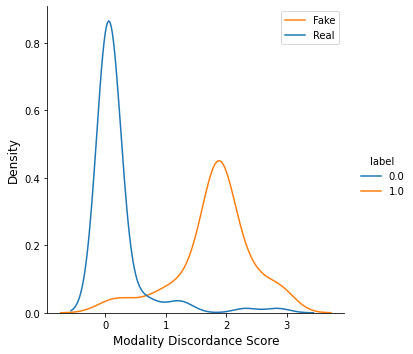

In [22]:
plt.figure(figsize=(3, 3))
sns.displot(data=df_mean, x="cluster_dist", hue="label",kind="kde")
plt.legend(['Fake', "Real"])
plt.xlabel('Modality Discordance Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
# plt.savefig("Gossipcop_validation_kde.pdf", bbox_inches="tight")
plt.show()

## RQ

In [25]:
## Prepare input as the multimodal vectors for t-SNE plots and further analysis
X = df_mean[['col_'+str(i) for i in range(1,model_parameters.MULTIMODAL_SPACE_DIM+1)]].to_numpy()
Y_hue = df_mean['label'].to_numpy()
clust_size = df_mean['cluster_dist'].to_numpy()
nb_components = 2

In [26]:
# X_2d = misc_title.plot_bubbles(X, clust_size, Y_hue, nb_components)

## RQ 

In [27]:
df_dist = misc_title.create_dist_df(df_space, df_mean, model_parameters.MULTIMODAL_SPACE_DIM)

100%|██████████| 680/680 [00:00<00:00, 27062.85it/s]


In [28]:
df_dist[df_dist['label']==1]

,title_text,text_img1,text_img2,text_img3,title_img1,title_img2,title_img3,img1_img2,img1_img3,"img2_img3, nb_imgs",img2_img3,nb_imgs,label
2,0.636746,3.878267,NaN,NaN,3.920002,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0
4,1.377144,3.440352,3.440352,1.534566,2.913980,2.913980,0.459574,0.000000,3.085718,NaN,3.085718,4,1.0
6,0.488200,2.771492,2.771492,NaN,2.645906,2.645906,NaN,0.000000,NaN,NaN,NaN,3,1.0
7,2.872352,0.602963,NaN,NaN,2.742515,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0
8,0.659083,2.219151,1.553188,NaN,1.772770,1.096978,NaN,0.721672,NaN,NaN,NaN,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,0.427514,3.162124,3.162124,NaN,3.297860,3.297860,NaN,0.000000,NaN,NaN,NaN,3,1.0
672,0.728555,1.672021,NaN,NaN,1.855270,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0
673,0.776976,2.486563,2.486563,NaN,2.331251,2.331251,NaN,0.000000,NaN,NaN,NaN,3,1.0
675,0.577799,2.741995,2.741995,NaN,2.699922,2.699922,NaN,0.000000,NaN,NaN,NaN,3,1.0


## Store distance between each component separately for Real and Fake samples 

a_b_<t/f> : distance between a and b for t:Real or f: Fake samples

im1 - Image 1 / Top image

ims - other images (non-first)

text - content body

title - title of sample

In [29]:
text_im1_t = df_dist[df_dist['label']==0]['text_img1'].to_numpy()
text_im1_f = df_dist[df_dist['label']==1]['text_img1'].to_numpy()

In [30]:
title_im1_t = df_dist[df_dist['label']==0]['title_img1'].to_numpy()
title_im1_f = df_dist[df_dist['label']==1]['title_img1'].to_numpy()

In [31]:
text_ims_t = np.concatenate((df_dist[df_dist['label']==0]['text_img2'].dropna().to_numpy(), df_dist[df_dist['label']==0]['text_img3'].dropna().to_numpy()))
text_ims_f = np.concatenate((df_dist[df_dist['label']==1]['text_img2'].dropna().to_numpy(), df_dist[df_dist['label']==1]['text_img3'].dropna().to_numpy()))

In [32]:
title_ims_t = np.concatenate((df_dist[df_dist['label']==0]['title_img2'].dropna().to_numpy(), df_dist[df_dist['label']==0]['title_img3'].dropna().to_numpy()))
title_ims_f = np.concatenate((df_dist[df_dist['label']==1]['title_img2'].dropna().to_numpy(), df_dist[df_dist['label']==1]['title_img3'].dropna().to_numpy()))

In [33]:
title_text_t = df_dist[df_dist['label']==0]['title_text']
title_text_f = df_dist[df_dist['label']==1]['title_text']

In [34]:
im1_ims_t = np.concatenate((df_dist[df_dist['label']==0]['img1_img2'].dropna().to_numpy(), df_dist[df_dist['label']==0]['img1_img3'].dropna().to_numpy()))
im1_ims_f = np.concatenate((df_dist[df_dist['label']==1]['img1_img2'].dropna().to_numpy(), df_dist[df_dist['label']==1]['img1_img3'].dropna().to_numpy()))

In [35]:
## For statistical tests
from scipy.stats import mannwhitneyu, f_oneway, kruskal

## Title is closer to 1st image when article is real than fake

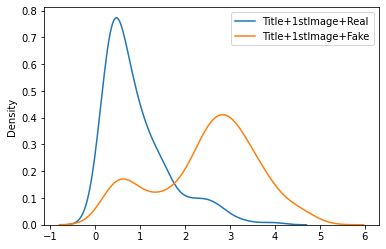

In [36]:
sns.kdeplot(title_im1_t, label="Title+1stImage+Real")
sns.kdeplot(title_im1_f, label="Title+1stImage+Fake")
plt.legend()
plt.show()

## Title is far away from from first image when article is real than the other images peresnt (ie, to get the attention) 

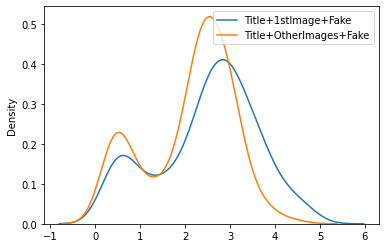

In [37]:
sns.kdeplot(title_im1_f, label="Title+1stImage+Fake")
sns.kdeplot(title_ims_f, label="Title+OtherImages+Fake")
plt.legend()
plt.show()

In [38]:
# compare samples
stat, p = f_oneway(title_im1_f, title_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=25.633, p=0.000
Different distributions (reject H0)


In [39]:
# compare samples
stat, p = mannwhitneyu(title_im1_f, title_ims_f)

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=65374.000, p=0.000
Different distribution (reject H0)


In [40]:
# compare samples
stat, p = kruskal(title_im1_f, title_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=31.959, p=0.000
Different distributions (reject H0)


## Distance between Image1 and other images is less when sample is real

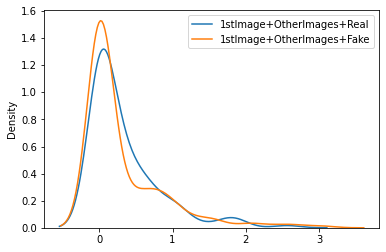

In [41]:
sns.kdeplot(im1_ims_t, label="1stImage+OtherImages+Real")
sns.kdeplot(im1_ims_f, label="1stImage+OtherImages+Fake")
plt.legend()
plt.show()

In [42]:
# compare samples
stat, p = f_oneway(im1_ims_t, im1_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=0.062, p=0.803
Same distributions (fail to reject H0)


In [43]:
# compare samples
stat, p = mannwhitneyu(im1_ims_t, im1_ims_f)

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=20148.000, p=0.008
Different distribution (reject H0)


In [44]:
# compare samples
stat, p = kruskal(im1_ims_t, im1_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=5.849, p=0.016
Different distributions (reject H0)


In [45]:
# compare samples
stat, p = f_oneway(text_im1_f, text_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=29.905, p=0.000
Different distributions (reject H0)
